In [1]:
!git clone https://github.com/Frostday/Lane-Segmentation.git

Cloning into 'Lane-Segmentation'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (32/32), 353.49 MiB | 10.06 MiB/s, done.
Updating files: 100% (17/17), done.


In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import random
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread, imshow,show
from skimage.transform import resize
from glob import glob

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *

In [ ]:
!mkdir data/etc
!mv data/image/*_save.png data/etc

In [3]:
sorted(os.listdir('data/images'))

['Screenshot (309).png',
 'Screenshot (310).png',
 'Screenshot (311).png',
 'Screenshot (312).png',
 'Screenshot (313).png',
 'Screenshot (314).png',
 'Screenshot (317).png',
 'Screenshot (318).png',
 'Screenshot (319).png',
 'Screenshot (321).png',
 'Screenshot (322).png',
 'Screenshot (323).png',
 'Screenshot (324).png',
 'Screenshot (325).png',
 'Screenshot (326).png',
 'Screenshot (353).png',
 'Screenshot (354).png',
 'Screenshot (355).png',
 'Screenshot (356).png',
 'Screenshot (357).png',
 'Screenshot (358).png',
 'Screenshot (359).png',
 'Screenshot (361).png',
 'Screenshot (362).png',
 'Screenshot (363).png',
 'Screenshot (364).png',
 'Screenshot (366).png',
 'Screenshot (367).png',
 'Screenshot (368).png',
 'Screenshot (369).png',
 'Screenshot (370).png',
 'Screenshot (371).png',
 'Screenshot (372).png',
 'Screenshot (373).png',
 'Screenshot (374).png',
 'Screenshot (375).png',
 'Screenshot (376).png',
 'Screenshot (377).png',
 'Screenshot (378).png',
 'Screenshot (379).png',


In [4]:
sorted(os.listdir('data/semantic'))

['Screenshot (309).png___fuse.png',
 'Screenshot (310).png___fuse.png',
 'Screenshot (311).png___fuse.png',
 'Screenshot (312).png___fuse.png',
 'Screenshot (313).png___fuse.png',
 'Screenshot (314).png___fuse.png',
 'Screenshot (317).png___fuse.png',
 'Screenshot (318).png___fuse.png',
 'Screenshot (319).png___fuse.png',
 'Screenshot (321).png___fuse.png',
 'Screenshot (322).png___fuse.png',
 'Screenshot (323).png___fuse.png',
 'Screenshot (324).png___fuse.png',
 'Screenshot (325).png___fuse.png',
 'Screenshot (326).png___fuse.png',
 'Screenshot (353).png___fuse.png',
 'Screenshot (354).png___fuse.png',
 'Screenshot (355).png___fuse.png',
 'Screenshot (356).png___fuse.png',
 'Screenshot (357).png___fuse.png',
 'Screenshot (358).png___fuse.png',
 'Screenshot (359).png___fuse.png',
 'Screenshot (361).png___fuse.png',
 'Screenshot (362).png___fuse.png',
 'Screenshot (363).png___fuse.png',
 'Screenshot (364).png___fuse.png',
 'Screenshot (366).png___fuse.png',
 'Screenshot (367).png___fus

In [5]:
len(os.listdir('data/images'))

200

In [2]:
# random seed 설정
tf.random.set_seed(42)

In [3]:
image_width, image_height = 256, 256

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=image_height,
                        width=image_width,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=image_width,
                        height=image_height
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=image_width,
                    height=image_height
                    )
                ])

In [11]:
dir_path = os.getenv('HOME')+'/aiffel/dlthon/data/'

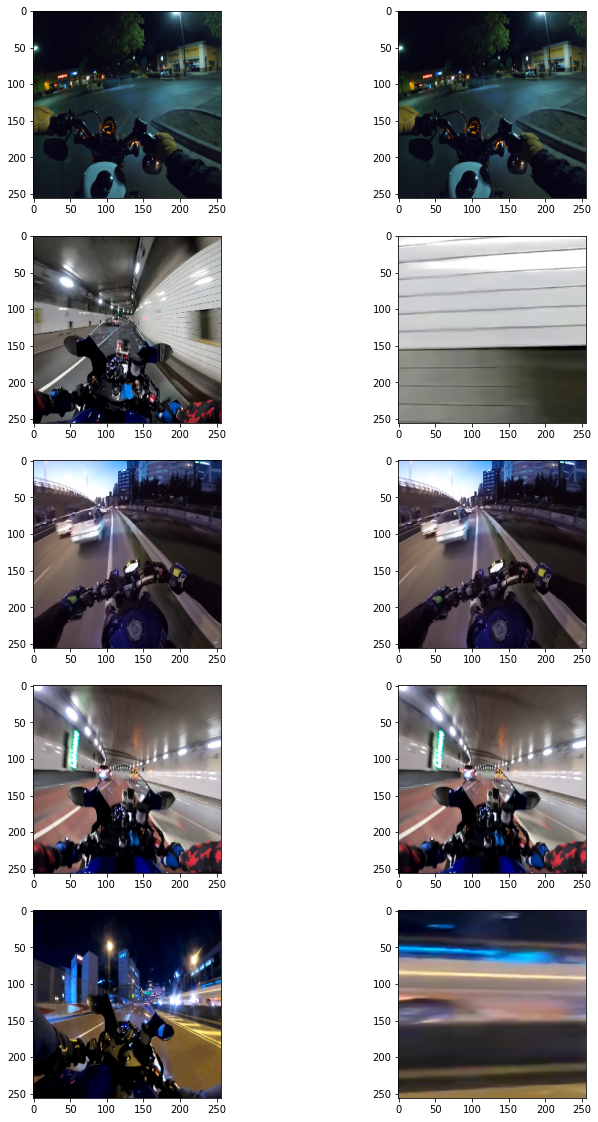

In [33]:
augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "images", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

데이터 확인

In [34]:
input_labels = glob(os.path.join(dir_path, "semantic", "*.png"))

In [35]:
input_labels.sort()
input_images.sort()

In [36]:
image = imread(input_images[0])[:,:,:3]
label = imread(input_labels[0])[:,:,:3]
print(image.shape, label.shape)

(1080, 1920, 3) (1080, 1920, 3)


In [37]:
data = {
  "image": image,
  "mask": label,
  }
image_data = {"image":image,"mask":label}
resized = augmentation_test(**image_data)
# resized_label = augmentation_test(**label_data)
print(resized['image'].shape, resized['mask'].shape)

(256, 256, 3) (256, 256, 3)


In [38]:
# 클래스 컬러와 클래스 매핑을 추출하는 함수
def extract_class_color_mapping(color_mask):
    unique_colors = np.unique(color_mask.reshape(-1, 3), axis=0)
    class_mapping = {}
    for idx, color in enumerate(unique_colors):
        class_mapping[tuple(color)] = idx
    return class_mapping

def map_color_mask_to_integer(color_mask, mapping):
    integer_mask = np.zeros(color_mask.shape[:-1], dtype=np.uint8)
    for row in range(color_mask.shape[0]):
        for col in range(color_mask.shape[1]):
            color = tuple(color_mask[row, col])
            if color in mapping:
                integer_mask[row, col] = mapping[color]
    return integer_mask

In [39]:
# 클래스 컬러와 매핑 추출
class_mapping = extract_class_color_mapping(resized['mask'])

# 결과 출력
print(class_mapping)

{(57, 234, 92): 0, (65, 117, 6): 1, (74, 144, 226): 2, (155, 155, 155): 3, (245, 166, 35): 4, (248, 231, 28): 5}


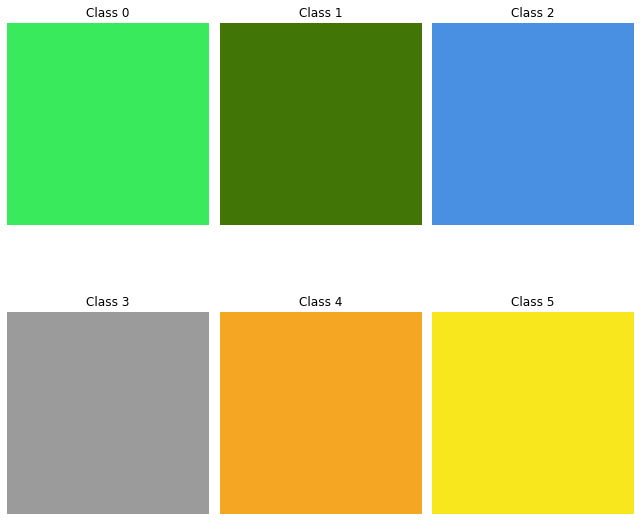

In [40]:
# 클래스 별 컬러값 (8비트 RGB)
class_colors = {
    0: (57, 234, 92),
    1: (65, 117, 6),
    2: (74, 144, 226),
    3: (155, 155, 155),
    4: (245, 166, 35),
    5: (248, 231, 28)
}

# 각 클래스 별로 서브플롯에 그릴 그래프 설정
plt.figure(figsize=(9, 9))
for class_id, color in class_colors.items():
    ax = plt.subplot(2, 3, class_id + 1)
    ax.set_title(f"Class {class_id}")
    ax.imshow(np.full((3, 3, 3), color, dtype=np.uint8))
    ax.axis('off')

plt.tight_layout()
plt.show()


|label|class|
|:--:|:--:|
|0| 'Movable'|
|1| 'Rider'|
|2|'My bike'|
|3|'Road'|
|4|'Undrivable'|
|5|'Lanemark'|

In [41]:
# 컬러 시맨틱 세그멘테이션 마스크를 정수로 변환
integer_mask = map_color_mask_to_integer(resized['mask'], class_mapping)
integer_mask.shape

(256, 256)

In [42]:
reverse_mapping = {v:k for k,v in class_mapping.items()}
def map_integer_mask_to_color(integer_mask, reverse_mapping):
    color_mask = np.zeros((integer_mask.shape[0], integer_mask.shape[1], 3), dtype=np.uint8)
    for row in range(integer_mask.shape[0]):
        for col in range(integer_mask.shape[1]):
            class_idx = integer_mask[row, col]
            color = reverse_mapping[class_idx]
            # 컬러 값을 [0, 255] 범위로 스케일링
            scaled_color = np.clip(color, 0, 255)
            color_mask[row, col] = scaled_color

    return color_mask

restored_color_mask = map_integer_mask_to_color(integer_mask, reverse_mapping)

In [43]:
restored_color_mask.shape

(256, 256, 3)

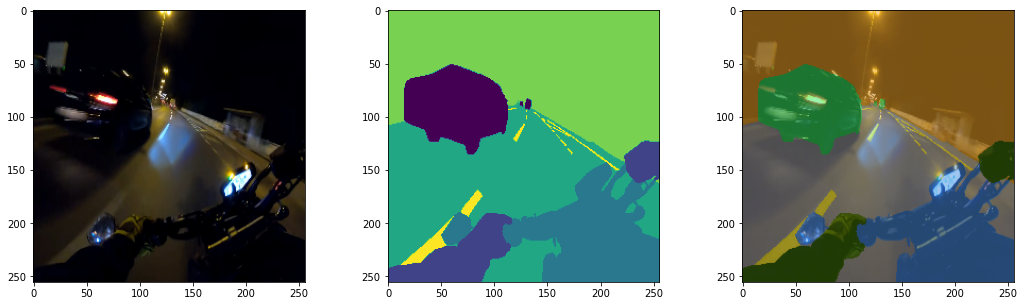

In [44]:
plt.figure(figsize = (18,5))
plt.subplot(1, 3, 1)
plt.imshow(resized["image"])
plt.subplot(1, 3, 2)
plt.imshow(integer_mask)
plt.subplot(1, 3, 3)
plt.imshow(Image.blend(Image.fromarray(resized["image"]),Image.fromarray(restored_color_mask), alpha=0.5))
plt.show()

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(image_width,image_height, 3),
               output_size=(image_width, image_height, 3),
               is_train=True,
               is_val=False,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    if not is_train and not is_val:
        self.batch_size = 1
    self.is_train = is_train
    self.is_val = is_val
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    self.data = self.load_dataset()

  def load_dataset(self):
    
    input_images = glob(os.path.join(self.dir_path, "images", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]
    
    random.shuffle(data)
    total_samples = len(data)

    train_ratio = 0.75
    val_ratio = 0.15
    test_ratio = 0.1

    train_split = int(total_samples * train_ratio)
    val_split = int(total_samples * (train_ratio + val_ratio))

    if self.is_train:
        return data[:train_split]
    if self.is_val :
        # validation을 위해 30개 따로 뺌
        return data[train_split:val_split]
    # 아무조건이 없으면 비교실험을 위한 20개 따로 뺌
    return data[val_split:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size[:2]])
        
    for i, data in enumerate(batch_data):
        input_img_path, output_path = data
        _input = imread(input_img_path)[:,:,:3]
        _output = imread(output_path)[:,:,:3]
        data = {
          "image": _input,
          "mask": _output,
          }
        
        augmented = self.augmentation(**data)
        
        image_array = augmented["image"]/255
        inputs[i] = image_array # np.transpose(image_array, (2, 0, 1))
        
        
        integer_mask = map_color_mask_to_integer(augmented['mask'], class_mapping)
        outputs[i] = integer_mask
        
        return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
        np.random.shuffle(self.indexes)
    return self.indexes

In [13]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = DataGenerator(
    dir_path, 
    augmentation=augmentation,
)
val_generator = DataGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train = False,
    is_val = True
)
test_generator = DataGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train = False,
    is_val = False
)

In [14]:
train_generator.batch_size,val_generator.batch_size,test_generator.batch_size

(16, 16, 1)

In [15]:
len(train_generator),len(val_generator),len(test_generator) # *16 해야 데이터 수 근사

(10, 2, 20)

In [31]:
for image, mask in train_generator:
        sample_image, sample_mask = image, mask
        break
        
sample_image.shape, sample_mask.shape

((16, 256, 256, 3), (16, 256, 256))

In [34]:
def display(display_list, titles=[], display_string=None):
    ''' displays list of images/masks'''
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        try:
            img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        except: # mask => 1-channel
            img_arr = display_list[i]
        plt.imshow(img_arr)
    
    plt.show()

def show_image_from_dataset(dataset,n_show = 2):
    
    for i in range(n_show):
        for image, mask in dataset:
            sample_image, sample_mask = image, mask
            break
        display([sample_image[0], sample_mask[0]], titles=['Image', 'True Mask'])

>>>>>> Train Image


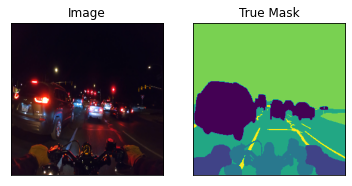

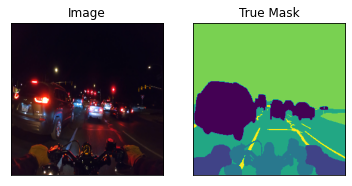

>>>>>> Test Image


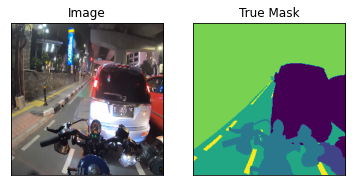

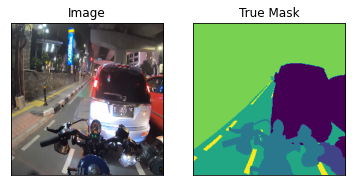

In [35]:
# display an image from the train set
print('>>>>>> Train Image')
show_image_from_dataset(val_generator)
# display an image from the test set
print('>>>>>> Test Image')
show_image_from_dataset(test_generator)

## Unet

In [16]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [17]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

In [18]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    layers.append(x)
    x = MaxPooling2D() (x)
    x = BatchNormalization()(x)
    f = f*2
  ff2 = 64
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = BatchNormalization()(x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = BatchNormalization()(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

load_pretrained

In [19]:
"""
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)
"""

def iou(y_true, y_pred):
    num_classes = 6
    
    total_intersection = np.zeros(num_classes)
    total_union = np.zeros(num_classes)
    
    y_pred = tf.math.argmax(y_pred, axis=1)
    
    for class_idx in range(num_classes):
        total_intersection[class_idx] += np.sum(np.logical_and(y_true == class_idx, y_pred == class_idx))
        total_union[class_idx] += np.sum(np.logical_or(y_true == class_idx, y_pred == class_idx))
        
    ious = np.divide(total_intersection, total_union, out=np.zeros_like(total_intersection), where=total_union != 0)
    total_mIOU = np.mean(ious)
    
    return total_mIOU


In [20]:
model = unet()

opt = tf.keras.optimizers.Adam(0.001)
metrics = [iou]

model.compile(loss=dice_coef_loss,
              optimizer=opt,
              metrics=metrics)

In [21]:
model.load_weights('Lane-Segmentation/pretrained models/UNET-BN-10-0.128840.hdf5')

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         batch_normalization[0][0]        
______________________________________________________________________________________________

In [45]:
pred_masks = model.predict(test_generator)

In [47]:
pred_masks[0].shape

(256, 256, 1)

In [78]:
np.where(pred_masks[0]>=0.5, 1, 0).shape

(256, 256, 1)

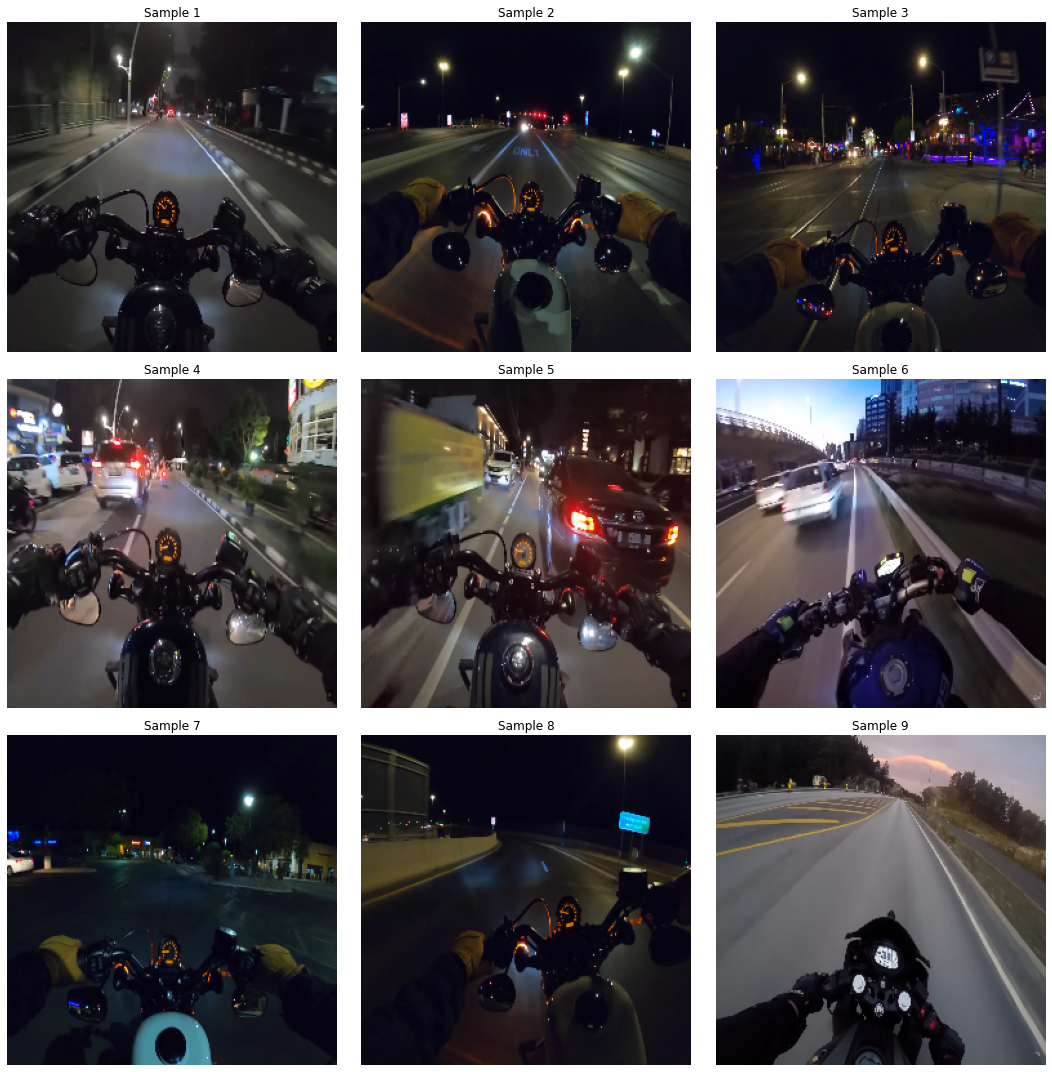

In [86]:
plt.figure(figsize=(15, 15))

for i, (image, label) in enumerate(test_generator):
    if i == 9:  # 9개의 이미지만 표시
        break
    
    plt.subplot(3, 3, i+1)
    
    # 이미지 가져오기
    image = tf.squeeze(image, [0]).numpy()    
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Sample {i+1}")
    
plt.tight_layout()
plt.show()

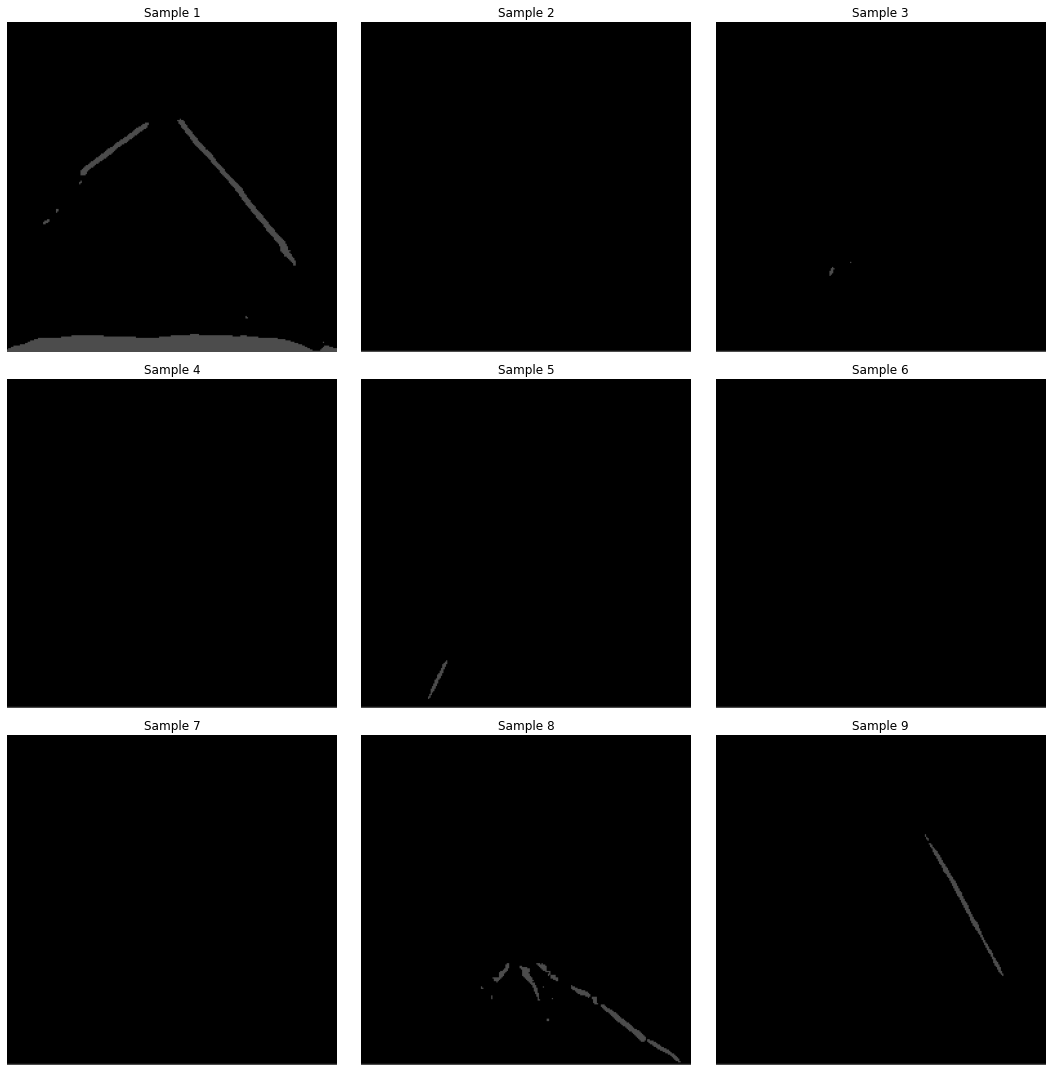

In [106]:
plt.figure(figsize=(15, 15))

for i, (image, label) in enumerate(test_generator):
    if i == 9:  # 9개의 이미지만 표시
        break
    
    plt.subplot(3, 3, i+1)
    
    # 이미지 가져오기
    image = tf.squeeze(image, [0]).numpy()
    
    # 마스크 이진화
    threshold = 0.5
    mask = pred_masks[i, ..., 0]  # 마스크의 차원 (256, 256, 1)에서 (256, 256)으로 변경
    binary_mask = (mask > threshold).astype(np.uint8)
    
    # 마스크를 0-255 값으로 스케일링
    binary_mask = binary_mask * 255
    
    # 이미지와 마스크를 PIL 이미지로 변환
    image_pil = Image.fromarray(image.astype(np.uint8))
    mask_pil = Image.fromarray(binary_mask)  # 'L'은 8-bit 흑백 이미지를 의미
    
    # 이미지와 마스크 섞기
    blended_image = Image.blend(image_pil, mask_pil.convert('RGB'), alpha=0.3)
    
    plt.imshow(blended_image)
    plt.axis('off')
    plt.title(f"Sample {i+1}")
    
plt.tight_layout()
plt.show()


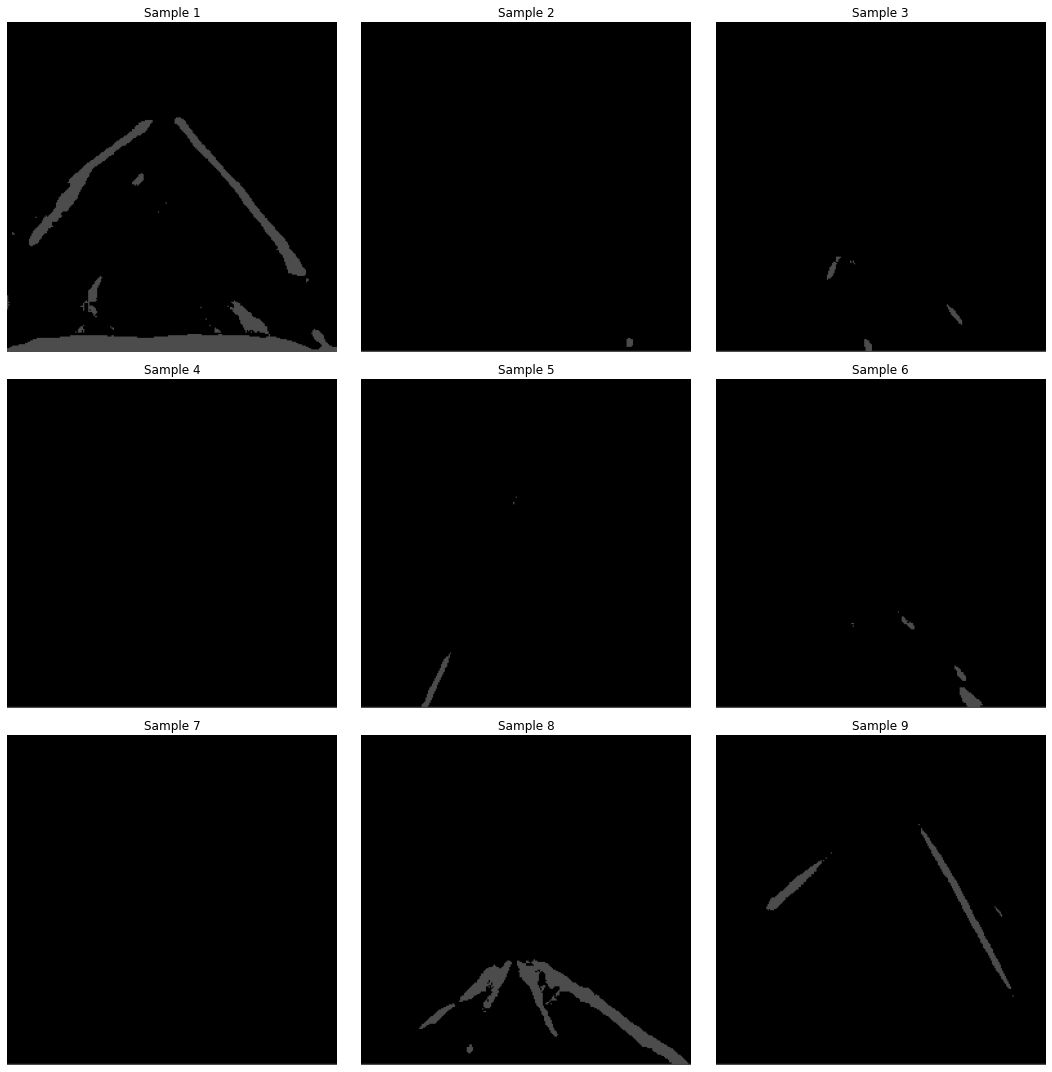

In [101]:
plt.figure(figsize=(15, 15))

for i, (image, label) in enumerate(test_generator):
    if i == 9:  # 9개의 이미지만 표시
        break
    
    plt.subplot(3, 3, i+1)
    
    # 이미지 가져오기
    image = tf.squeeze(image, [0]).numpy()
    
    # 마스크 이진화
    threshold = 0.1
    mask = pred_masks[i, ..., 0]  # 마스크의 차원 (256, 256, 1)에서 (256, 256)으로 변경
    binary_mask = (mask > threshold).astype(np.uint8)
    
    # 마스크를 0-255 값으로 스케일링
    binary_mask = binary_mask * 255
    
    # 이미지와 마스크를 PIL 이미지로 변환
    image_pil = Image.fromarray(image.astype(np.uint8))
    mask_pil = Image.fromarray(binary_mask)  # 'L'은 8-bit 흑백 이미지를 의미
    
    # 이미지와 마스크 섞기
    blended_image = Image.blend(image_pil, mask_pil.convert('RGB'), alpha=0.3)
    
    plt.imshow(blended_image)
    plt.axis('off')
    plt.title(f"Sample {i+1}")
    
plt.tight_layout()
plt.show()


### Fine-tuning (시도 only)

In [72]:
# 원래 모델의 마지막 레이어를 제외한 새로운 모델 아키텍처 정의
temp_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Conv2D 레이어 추가하여 새로운 모델 완성
new_outputs = Conv2D(num_classes, 1, activation='softmax')(temp_model.output)
multiclass_unet = Model(inputs=temp_model.input, outputs=new_outputs)

In [73]:
multiclass_unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 256, 256, 8)  224         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 256, 256, 8)  32          conv2d_134[0][0]                 
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 8)  584         batch_normalization_190[0][0]    
____________________________________________________________________________________________

In [74]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for i in range(num):
            for image, mask in dataset:
                masks = tf.expand_dims(mask, -1)
                pred_masks = model.predict(image)
                display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


In [75]:
epochs = 100

lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[DisplayCallback(val_generator)],
    epochs=epochs,
)

Epoch 1/100


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:622 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/utils.py:72 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv2d_134/kernel:0', 'conv2d_134/bias:0', 'batch_normalization_190/gamma:0', 'batch_normalization_190/beta:0', 'conv2d_135/kernel:0', 'conv2d_135/bias:0', 'batch_normalization_191/gamma:0', 'batch_normalization_191/beta:0', 'batch_normalization_192/gamma:0', 'batch_normalization_192/beta:0', 'conv2d_136/kernel:0', 'conv2d_136/bias:0', 'batch_normalization_193/gamma:0', 'batch_normalization_193/beta:0', 'conv2d_137/kernel:0', 'conv2d_137/bias:0', 'batch_normalization_194/gamma:0', 'batch_normalization_194/beta:0', 'batch_normalization_195/gamma:0', 'batch_normalization_195/beta:0', 'conv2d_138/kernel:0', 'conv2d_138/bias:0', 'batch_normalization_196/gamma:0', 'batch_normalization_196/beta:0', 'conv2d_139/kernel:0', 'conv2d_139/bias:0', 'batch_normalization_197/gamma:0', 'batch_normalization_197/beta:0', 'batch_normalization_198/gamma:0', 'batch_normalization_198/beta:0', 'conv2d_140/kernel:0', 'conv2d_140/bias:0', 'batch_normalization_199/gamma:0', 'batch_normalization_199/beta:0', 'conv2d_141/kernel:0', 'conv2d_141/bias:0', 'batch_normalization_200/gamma:0', 'batch_normalization_200/beta:0', 'batch_normalization_201/gamma:0', 'batch_normalization_201/beta:0', 'conv2d_142/kernel:0', 'conv2d_142/bias:0', 'batch_normalization_202/gamma:0', 'batch_normalization_202/beta:0', 'conv2d_143/kernel:0', 'conv2d_143/bias:0', 'batch_normalization_203/gamma:0', 'batch_normalization_203/beta:0', 'batch_normalization_204/gamma:0', 'batch_normalization_204/beta:0', 'conv2d_144/kernel:0', 'conv2d_144/bias:0', 'batch_normalization_205/gamma:0', 'batch_normalization_205/beta:0', 'conv2d_145/kernel:0', 'conv2d_145/bias:0', 'batch_normalization_206/gamma:0', 'batch_normalization_206/beta:0', 'batch_normalization_207/gamma:0', 'batch_normalization_207/beta:0', 'conv2d_146/kernel:0', 'conv2d_146/bias:0', 'batch_normalization_208/gamma:0', 'batch_normalization_208/beta:0', 'conv2d_147/kernel:0', 'conv2d_147/bias:0', 'batch_normalization_209/gamma:0', 'batch_normalization_209/beta:0', 'conv2d_transpose_30/kernel:0', 'conv2d_transpose_30/bias:0', 'batch_normalization_210/gamma:0', 'batch_normalization_210/beta:0', 'conv2d_148/kernel:0', 'conv2d_148/bias:0', 'batch_normalization_211/gamma:0', 'batch_normalization_211/beta:0', 'conv2d_149/kernel:0', 'conv2d_149/bias:0', 'batch_normalization_212/gamma:0', 'batch_normalization_212/beta:0', 'conv2d_transpose_31/kernel:0', 'conv2d_transpose_31/bias:0', 'batch_normalization_213/gamma:0', 'batch_normalization_213/beta:0', 'conv2d_150/kernel:0', 'conv2d_150/bias:0', 'batch_normalization_214/gamma:0', 'batch_normalization_214/beta:0', 'conv2d_151/kernel:0', 'conv2d_151/bias:0', 'batch_normalization_215/gamma:0', 'batch_normalization_215/beta:0', 'conv2d_transpose_32/kernel:0', 'conv2d_transpose_32/bias:0', 'batch_normalization_216/gamma:0', 'batch_normalization_216/beta:0', 'conv2d_152/kernel:0', 'conv2d_152/bias:0', 'batch_normalization_217/gamma:0', 'batch_normalization_217/beta:0', 'conv2d_153/kernel:0', 'conv2d_153/bias:0', 'batch_normalization_218/gamma:0', 'batch_normalization_218/beta:0', 'conv2d_transpose_33/kernel:0', 'conv2d_transpose_33/bias:0', 'batch_normalization_219/gamma:0', 'batch_normalization_219/beta:0', 'conv2d_154/kernel:0', 'conv2d_154/bias:0', 'batch_normalization_220/gamma:0', 'batch_normalization_220/beta:0', 'conv2d_155/kernel:0', 'conv2d_155/bias:0', 'batch_normalization_221/gamma:0', 'batch_normalization_221/beta:0', 'conv2d_transpose_34/kernel:0', 'conv2d_transpose_34/bias:0', 'batch_normalization_222/gamma:0', 'batch_normalization_222/beta:0', 'conv2d_156/kernel:0', 'conv2d_156/bias:0', 'batch_normalization_223/gamma:0', 'batch_normalization_223/beta:0', 'conv2d_157/kernel:0', 'conv2d_157/bias:0', 'batch_normalization_224/gamma:0', 'batch_normalization_224/beta:0', 'conv2d_transpose_35/kernel:0', 'conv2d_transpose_35/bias:0', 'batch_normalization_225/gamma:0', 'batch_normalization_225/beta:0', 'conv2d_158/kernel:0', 'conv2d_158/bias:0', 'batch_normalization_226/gamma:0', 'batch_normalization_226/beta:0', 'conv2d_159/kernel:0', 'conv2d_159/bias:0', 'batch_normalization_227/gamma:0', 'batch_normalization_227/beta:0', 'conv2d_160/kernel:0', 'conv2d_160/bias:0'].
